In [2]:
import nilearn
from nilearn.input_data import NiftiMapsMasker, NiftiLabelsMasker
from nilearn import datasets, plotting
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import jit

plt.style.use("~/.config/matplotlib/custom")

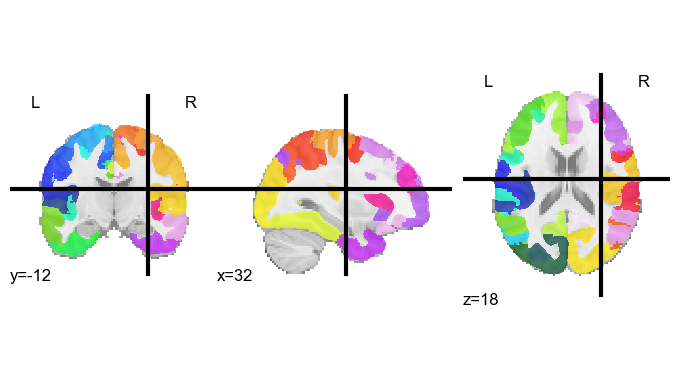

In [3]:
func = '/home/ilkin/Documents/GitHub/datasci/fmri/data/sub-001/ses-LSD/func/sub-001_ses-LSD_task-rest_run-01_bold.nii.gz'

atlas = datasets.fetch_atlas_schaefer_2018()
plotting.plot_roi(atlas.maps)

In [5]:
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
time_series = masker.fit_transform(func)
time_series.shape

(217, 400)

<Axes: >

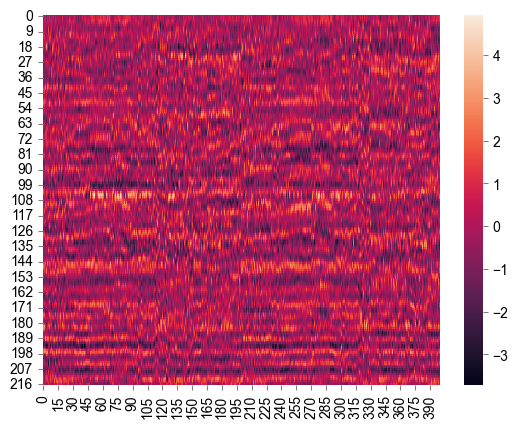

In [6]:
sns.heatmap(time_series)

In [78]:
pears = [[scipy.stats.pearsonr((time_series[:, i]), (time_series[:, j]))[0] for j in range(i+1, 400)] for i in range(400)]
spear = [[scipy.stats.spearmanr((time_series[:, i]), (time_series[:, j]))[0] for j in range(i+1, 400)] for i in range(400)]
kendt = [[scipy.stats.kendalltau((time_series[:, i]), (time_series[:, j]))[0] for j in range(i+1, 400)] for i in range(400)]

In [7]:

pears_mat = np.zeros((400, 400))
# spear_mat = np.zeros((400, 400))
# kendt_mat = np.zeros((400, 400))
for i in range(400):
    for j in range(i+1, 400):
        pears_mat[i, j] = scipy.stats.pearsonr((time_series[:, i]), (time_series[:, j]))[0]
        # spear_mat[i, j] = scipy.stats.spearmanr((time_series[:, i]), (time_series[:, j]))[0]
        # kendt_mat[i, j] = scipy.stats.kendalltau((time_series[:, i]), (time_series[:, j]))[0]

In [8]:
mat = pears_mat + pears_mat.T

In [9]:
for i in range(400):
    mat[i, i] = np.nan
bin = np.ceil(mat) * 2 -1

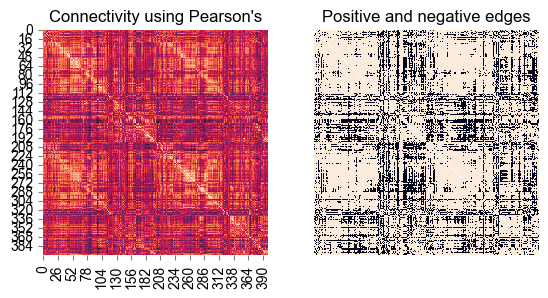

In [10]:
fig, ax = plt.subplots(1, 2)
ax[0].set_aspect('equal')
ax[0].set_yticklabels([])
ax[0].set_title("Connectivity using Pearson's")
ax[1].set_title("Positive and negative edges")
ax[1].set_aspect('equal')
sns.heatmap(mat, ax=ax[0], cbar=False)
sns.heatmap(bin, ax=ax[1], cbar=False)
plt.axis('off')
plt.show()

In [15]:
frus_mat = np.zeros((400, 400))

@jit
def ret_frus(frus_mat):
    bin_mat = frus_mat.copy()
    for i in range(398):
        for j in range(i+1, 399):
            for k in range(j+1, 400):
                y = mat[i,j]*mat[i,k]*mat[j,k]
                b = y < 0
                frus_mat[i, j] += y
                frus_mat[i, k] += y
                frus_mat[j, k] += y
                bin_mat[i, j] += b
                bin_mat[i, k] += b
                bin_mat[j, k] += b
    return frus_mat, bin_mat
frus_mat, bin_mat = ret_frus(frus_mat)

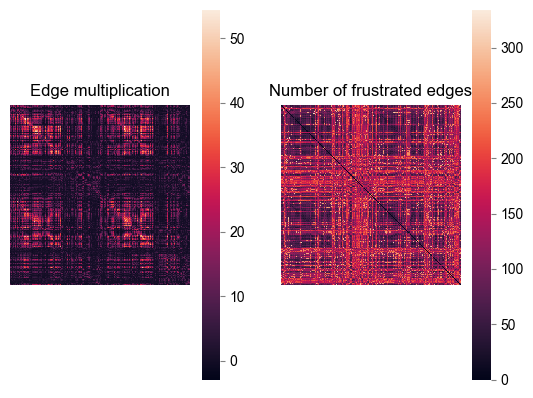

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].set_aspect('equal')
ax[0].axis('off')
ax[0].set_title('Edge multiplication')
ax[1].set_title('Number of frustrated edges')
ax[1].set_aspect('equal')
sns.heatmap(frus_mat + frus_mat.T, ax=ax[0])

sns.heatmap(bin_mat + bin_mat.T, ax=ax[1])
plt.axis('off')
plt.show()

/home/ilkin/Documents/GitHub/datasci/fmri/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ilkin/Documents/GitHub/datasci/fmri/.venv/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/ilkin/Documents/GitHub/datasci/fmri/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ilkin/Documents/GitHub/datasci/fmri/.venv/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, 

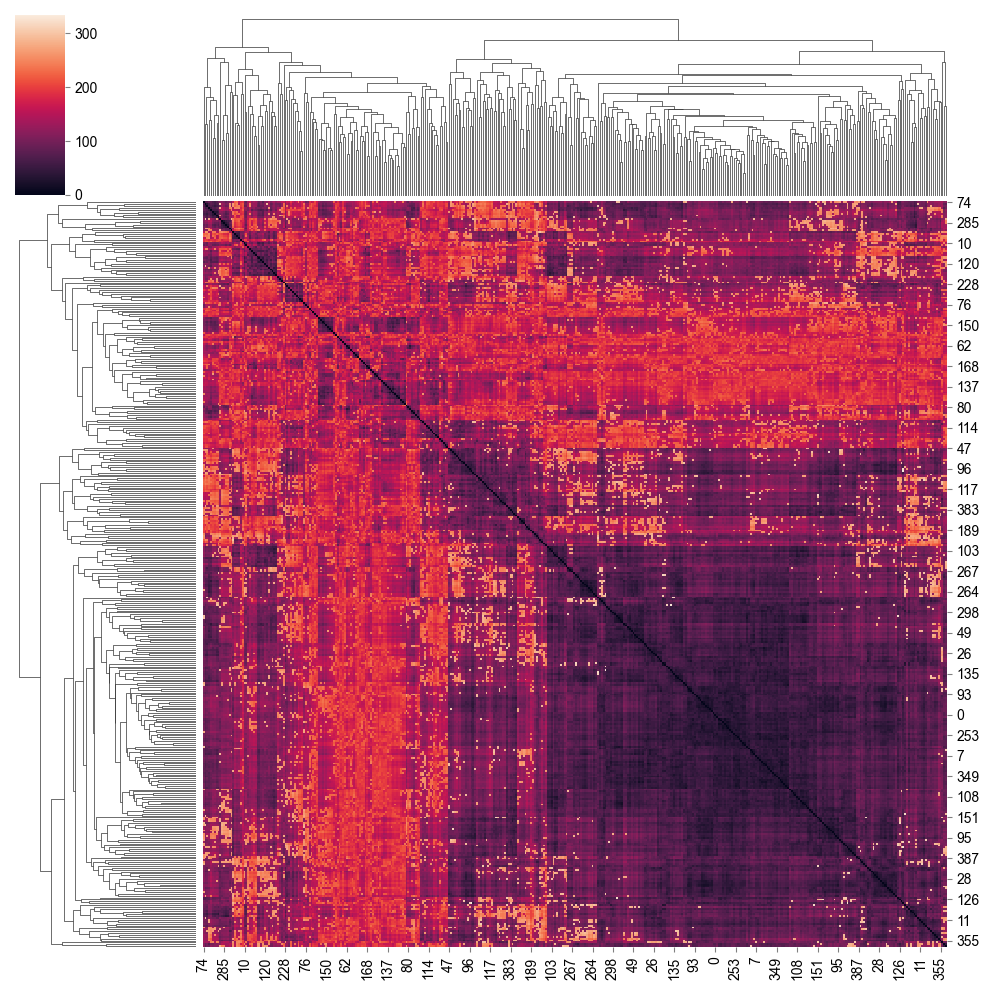

In [18]:
sns.clustermap(bin_mat + bin_mat.T)

/home/ilkin/Documents/GitHub/datasci/fmri/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ilkin/Documents/GitHub/datasci/fmri/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


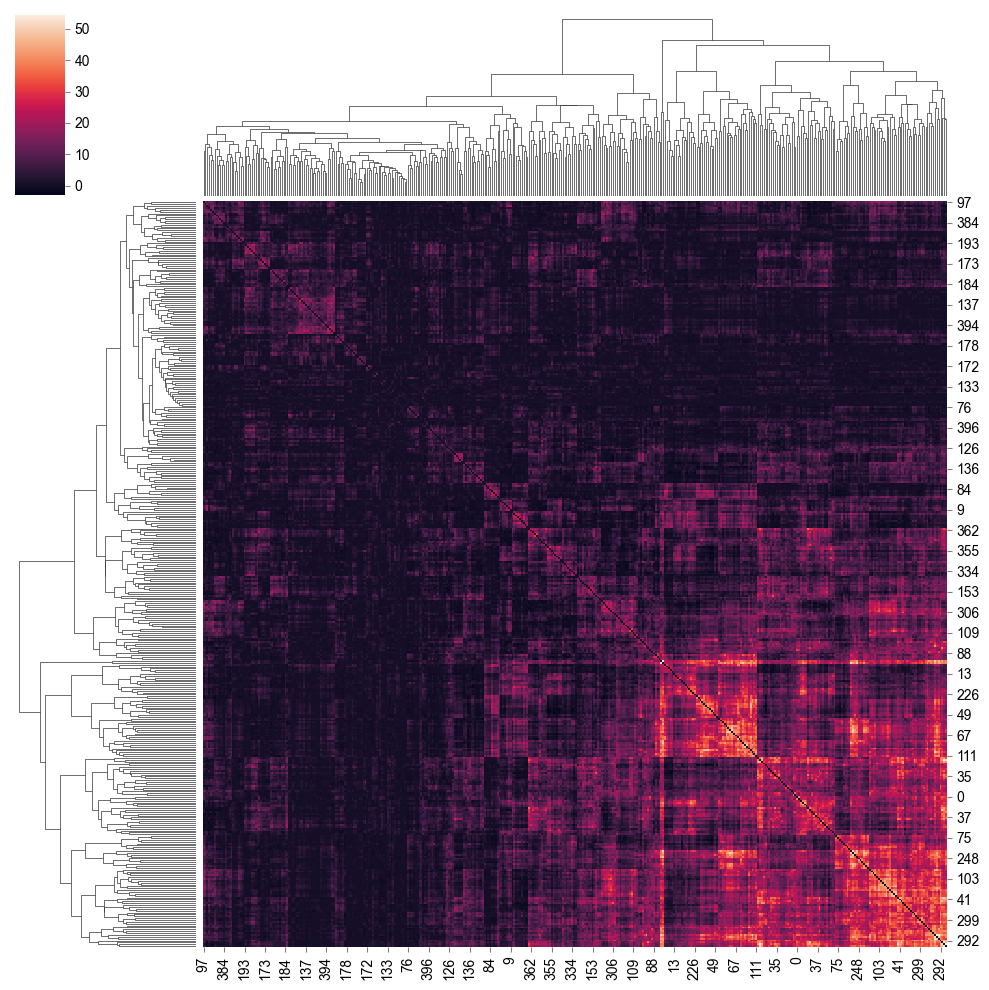

In [19]:
sns.clustermap(frus_mat + frus_mat.T)

In [155]:
pears_mat += pears_mat.T
spear_mat += spear_mat.T
kendt_mat += kendt_mat.T

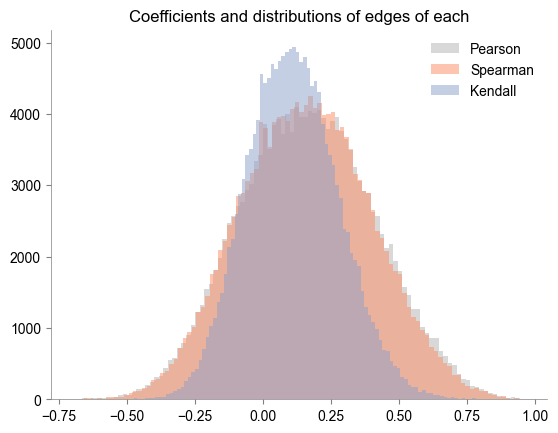

In [156]:

for i, j in zip([pears_mat, spear_mat, kendt_mat], ['Pearson', 'Spearman', 'Kendall']):
    plt.hist((i).flatten(), bins=100, alpha=0.5, label=j)
plt.title('Coefficients and distributions of edges of each')
plt.legend()
plt.show()

/home/ilkin/Documents/GitHub/datasci/fmri/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ilkin/Documents/GitHub/datasci/fmri/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


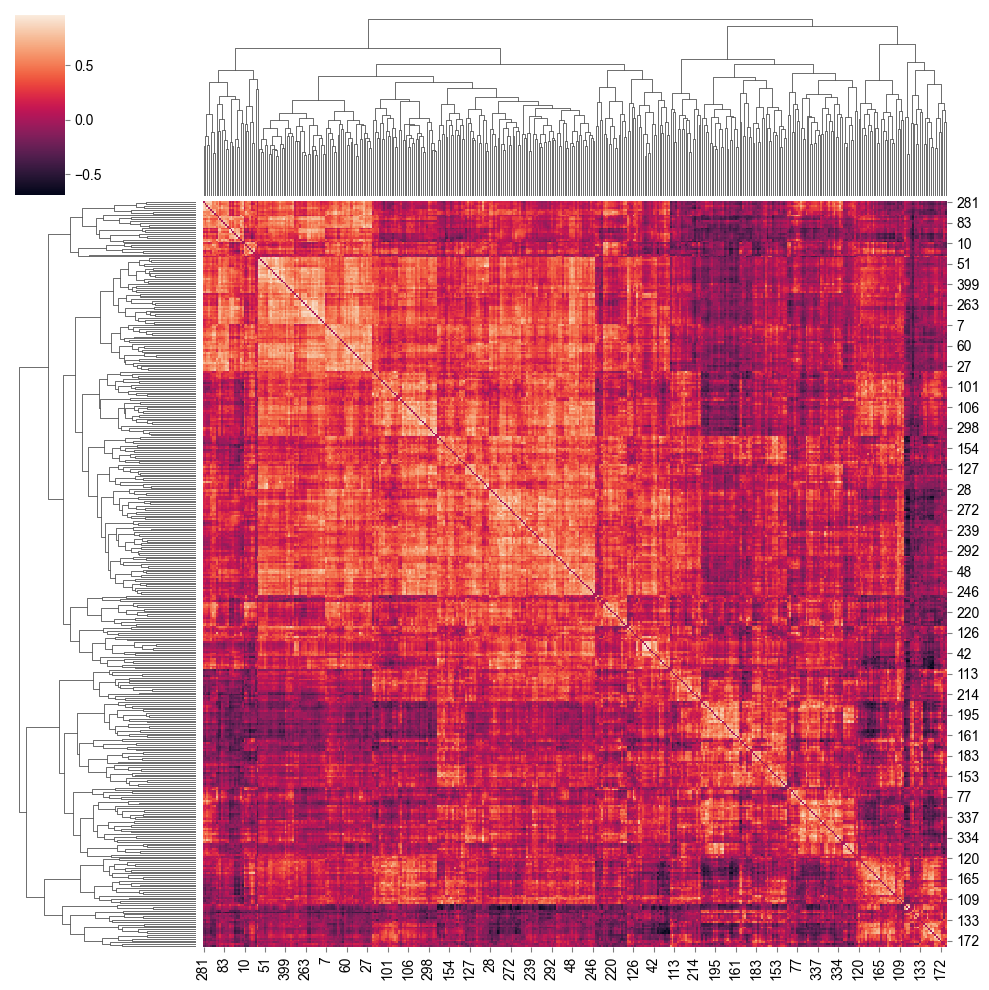

In [105]:
sns.clustermap(spear_mat)

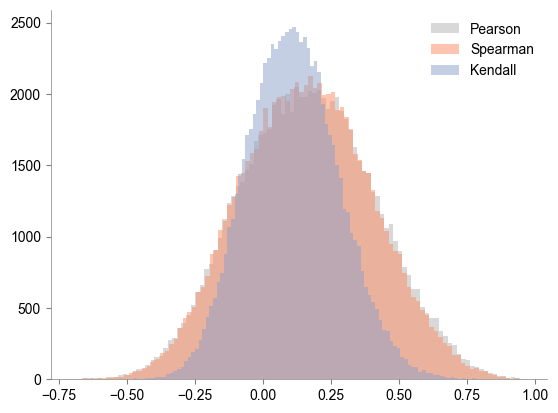

In [81]:
pears_list = []
spear_list = []
kendt_list = []
for i, j, k in zip(pears, spear, kendt):
    pears_list += i
    spear_list += j
    kendt_list += k
for i, j in zip([pears_list, spear_list, kendt_list], ['Pearson', 'Spearman', 'Kendall']):
    plt.hist(i, bins=100, alpha=0.5, label=j)
plt.legend()
plt.show()

In [45]:
fmri_data = nilearn.image.get_data(func)
fmri_data.shape

(91, 109, 91, 217)

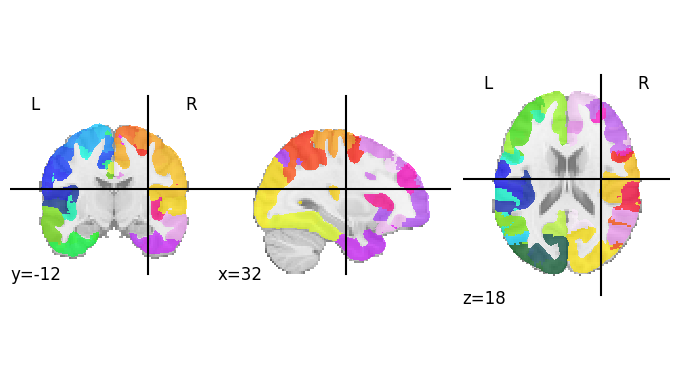

In [24]:
data = datasets.fetch_atlas_schaefer_2018()
plotting.plot_roi(data.maps)

In [15]:
maps_masker = NiftiMapsMasker(maps_img=data.maps, verbose=1)

In [30]:
d_img = nilearn.image.load_img('/home/ilkin/Documents/GitHub/datasci/fmri/data/sub-001/ses-LSD/func/sub-001_ses-LSD_task-rest_run-01_bold.nii.gz')
# d_img.slicer[0]
# signals = maps_masker.fit_transform(cmap)

IndexError: Scalar indices disallowed in spatial dimensions; Use `[x]` or `x:x+1`.

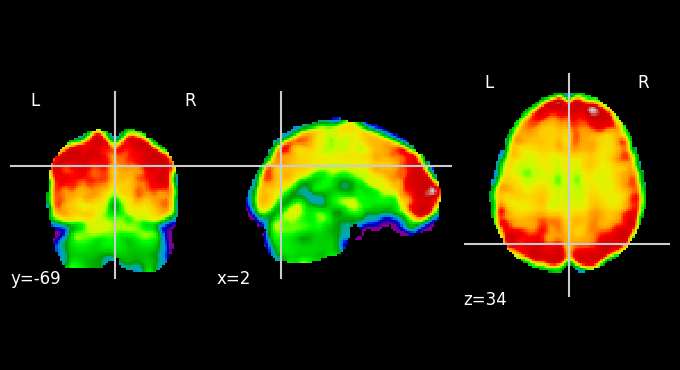

In [32]:
mean = nilearn.image.image.mean_img('/home/ilkin/Documents/GitHub/datasci/fmri/data/sub-001/ses-LSD/func/sub-001_ses-LSD_task-rest_run-01_bold.nii.gz')
plotting.plot_epi(mean)

In [36]:
singals = maps_masker.fit_transform(mean)

TypeError: NiftiMapsMasker.fit_transform() got an unexpected keyword argument 'verbose'